# Imports

In [1]:
# System and path operations
import sys
import os
from pathlib import Path
from glob import glob
sys.path.insert(0, '../') 

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *
from src.metrices import *

# Basic python data handling and visualization libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Libraries for image processing
from PIL import Image
import skimage
from skimage.io import imread, imsave
import tifffile as tiff

# Libraries for model evaluation and validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score


# TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import keras
from keras import backend as K
from keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau, 
                             CSVLogger, EarlyStopping)
from keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU


# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
# Setting GPU's number
physical_devices=tf.config.experimental.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
# tf.config.set_visible_devices(physical_devices[:],'GPU')
tf.config.set_visible_devices(physical_devices[3],'GPU')

In [4]:
# ngpu = 3
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
# # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.set_logical_device_configuration(gpus[ngpu], [tf.config.LogicalDeviceConfiguration(memory_limit=10240)])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [5]:
# Data to check that the model was correctly loaded
# test = tf.data.Dataset.from_tensor_slices(get_SPARCS('test', only_rgb=trained_with_RGB))
# test = test.batch(batch_size)

# Parameters

In [6]:
# Hyperparameters for the model
batch_size = 16

trained_with_RGB = True

# DeepLabV3+, CXNet and cloud-net need resizing since they have special layers
need_resizing = True

In [7]:
# Choose the model that you want to use for the scoring
model_name='UNet_SPARCS_epochs100_batch16'
model_name='CloudXNet_biome8_epochs200_batch16'


# Choose the dataset that you wwant the model to be scored on
# datasets = ['SPARCS', 'S2', 'Biome 8', 'Cloud38']
# datasets = ['SPARCS', 'Biome 8', 'Cloud38']

In [8]:
# custom_metrics = {'jaccard_coef': jaccard_coef, 'jaccard_coef_thresholded':jaccard_coef_thresholded, 'jaccard_coef_loss':jaccard_coef_loss, 
#                   'bce_dice_loss': bce_dice_loss, 'binary_mean_iou': BinaryMeanIoU}

# custom_objects = {
#     'bce_dice_loss': bce_dice_loss,
#     'jaccard_coef': jaccard_coef,
#     'jaccard_coef_thresholded' : jaccard_coef_thresholded,
#     'jaccard_coef_loss':jaccard_coef_loss,
# }

In [9]:
# Include the epoch in the file name (uses `str.format`)
ckpt_path = str(checkpoint_path / f"{model_name}/" / "cp-{epoch:04d}.ckpt")
ckpt_dir = os.path.dirname(ckpt_path)

# Load full model

In [10]:
# new_model = tf.keras.models.load_model(Path(saved_models_path, model_name))
# new_model = tf.keras.models.load_model(Path(saved_models_path, model_name), compile=False, custom_objects=custom_objects)
new_model = tf.keras.models.load_model(Path(saved_models_path, model_name), compile=False)


# Load training history
with open(Path(train_hystory_path, f'{model_name}.json'), 'r') as f:
    loaded_history = json.load(f)

# Check its architecture
new_model.summary()

2023-08-16 07:47:35.880322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 07:47:36.373464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c2:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 32  688        ['conv2d[0][0]']                 
 v2D)                           )                                                             

In [11]:
model = new_model
history = loaded_history

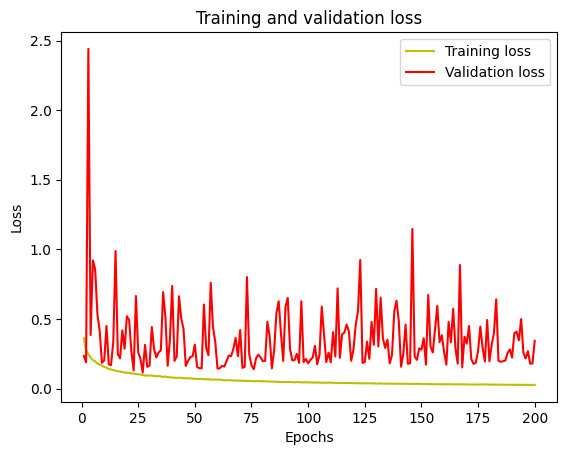

In [12]:
#plot the training and validation accuracy and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
history.keys()

dict_keys(['loss', 'binary_crossentropy', 'jaccard_coef_loss', 'jaccard_coef', 'jaccard_coef_thresholded', 'accuracy', 'auc', 'val_loss', 'val_binary_crossentropy', 'val_jaccard_coef_loss', 'val_jaccard_coef', 'val_jaccard_coef_thresholded', 'val_accuracy', 'val_auc'])

In [14]:
# auc = history['auc']
# val_auc = history['val_auc']

# auc = history['binary_mean_iou']
# val_auc = history['val_binary_mean_iou']

# plt.plot(epochs, auc, 'y', label='Training IOU')
# plt.plot(epochs, val_auc, 'r', label='Validation IOU')
# plt.title('Training and validation IOU')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Load weights from checkpoint

In [10]:
# Upload the last checkpoint
latest = tf.train.latest_checkpoint(ckpt_dir)

# Create a new model instance
# model = create_model(model_name='unet')
model = create_model(model_name='cloud_net')

# Load the previously saved weights
model.load_weights(latest)

2023-08-11 09:31:28.555316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 09:31:29.041522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [11]:
# Re-evaluate the model
# metric = BinaryMeanIoU()
# loss, metric = model.evaluate(test, verbose=2)
# print(f"Restored model, IOU: {metric}")

# Scoring

## Data loading

In [15]:
import numpy as np
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import accuracy_score, jaccard_score


import numpy as np
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import accuracy_score, jaccard_score

def print_metrics(y_true, y_pred):
    # Cast to float types
    y_true_f = y_true.astype('float32')
    y_pred_f = y_pred.astype('float32')
    
    y_true_flatten = y_true_f.reshape(-1)
    y_pred_flatten = y_pred_f.reshape(-1)
    
    print("Pixel Accuracy: ", accuracy_score(y_true_flatten, y_pred_flatten))
    print("Precision: ", precision_score(y_true_flatten, y_pred_flatten))
    print("Recall: ", recall_score(y_true_flatten, y_pred_flatten))
    print("F1 Score: ", f1_score(y_true_flatten, y_pred_flatten))
    print("AUC Score: ", roc_auc_score(y_true_flatten, y_pred_flatten))
    
    print("Dice Coefficient: ", K.eval(dice_coef(y_true_f, y_pred_f)))
    
    # Jaccard Score
    
    print("IoU (Jaccard Coefficient): ", K.eval(IoU(y_true_f, y_pred_f)))
    
    print("Jaccard Coefficient: ", jaccard(y_true_f, y_pred_f))

    print("Jaccard Score (IoU): ", jaccard_score(y_true_flatten, y_pred_flatten))
    

def find_best_threshold(prob_mask, y_true):
    best_threshold = 0
    best_iou = 0

    # Ensuring y_true is in correct data type
    y_true = y_true.astype('float32')
    
    for threshold in np.arange(0.0, 1.1, 0.1):  # You can adjust the range and step size as needed
        binary_mask = (prob_mask > threshold).astype('float32')
        
        assert binary_mask.shape == y_true.shape, "Shape mismatch between binary_mask and y_true!"
        
        # Compute Jaccard Score (IoU)
        # iou_score = jaccard_score(y_true.flatten(), binary_mask.flatten())
        iou_score = K.eval(IoU(tf.cast(y_true, tf.float32), tf.cast(binary_mask, tf.float32)))

        if iou_score > best_iou:
            best_iou = iou_score
            best_threshold = threshold

        print(f'Threshold: {threshold:.1f}, IoU: {iou_score:.4f}')

    print(f'\nBest Threshold: {best_threshold:.1f}, Best IoU: {best_iou:.4f}')
    return best_threshold



In [16]:
def load_sparcs():
    # Create two instances of the test generator
    train_gen_pred = get_SPARCS_generator('train', batch_size=batch_size, only_rgb=trained_with_RGB)
    val_gen_pred = get_SPARCS_generator('valid', batch_size=batch_size, only_rgb=trained_with_RGB)
    test_gen_pred = get_SPARCS_generator('test', batch_size=batch_size, only_rgb=trained_with_RGB)

    train_image_names = sorted(os.listdir(Path(sparcs_train_dir, "images_p/")))
    val_image_names = sorted(os.listdir(Path(sparcs_valid_dir, "images_p/")))
    test_image_names = sorted(os.listdir(Path(sparcs_test_dir, "images_p/")))

    # Define number of steps
    train_steps = math.ceil(len(train_image_names) / batch_size)
    val_steps = math.ceil(len(val_image_names) / batch_size)
    test_steps = math.ceil(len(test_image_names) / batch_size)

    # Predict on the train, val and test data
    y_pred_train = model.predict(train_gen_pred, steps=train_steps, verbose=0)
    y_pred_val = model.predict(val_gen_pred, steps=val_steps, verbose=0)
    y_pred_test = model.predict(test_gen_pred, steps=test_steps, verbose=0)

    # Collect true labels
    y_true_train = get_SPARCS('train', only_rgb=trained_with_RGB)[1]
    y_true_val = get_SPARCS('valid', only_rgb=trained_with_RGB)[1]
    y_true_test = get_SPARCS('test', only_rgb=trained_with_RGB)[1]

    # print(y_true_train.shape, y_pred_train.shape)
    # print(y_true_val.shape, y_pred_val.shape)
    # print(y_true_test.shape, y_pred_test.shape)

    return y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test


# def load_S2():
#     s2_test = get_S2(only_rgb=trained_with_RGB)
#     y_true_S2 = s2_test[1]
#     X = s2_test[0]

#     if need_resizing:
#         y_true_S2 = resize_image(y_true_S2, new_dim=((212, 256, 256, 1)))
#         X = resize_image(s2_test[0], new_dim=((212, 256, 256, 3))) if trained_with_RGB else resize_image(s2_test[0], new_dim=((212, 256, 256, 4)))

#     y_pred_S2 = model.predict(X)
#     print(y_true_S2.shape, y_pred_S2.shape)

#     return y_true_S2, y_pred_S2

# def load_s2():
#     # Create instances of the test generator
#     train_gen_pred = get_S2_generator('train', only_rgb=trained_with_RGB)
#     val_gen_pred = get_S2_generator('valid', only_rgb=trained_with_RGB)
#     test_gen_pred = get_S2_generator('test', only_rgb=trained_with_RGB)

#     train_image_names = sorted(os.listdir(Path(s2_train_dir, "images/")))
#     val_image_names = sorted(os.listdir(Path(s2_valid_dir, "images/")))
#     test_image_names = sorted(os.listdir(Path(s2_test_dir, "images/")))

#     # Define number of steps
#     train_steps = math.ceil(len(train_image_names) / batch_size)
#     val_steps = math.ceil(len(val_image_names) / batch_size)
#     test_steps = math.ceil(len(test_image_names) / batch_size)

#     # Predict on the train, val and test data
#     y_pred_train = model.predict(train_gen_pred, steps=train_steps)
#     y_pred_val = model.predict(val_gen_pred, steps=val_steps)
#     y_pred_test = model.predict(test_gen_pred, steps=test_steps)

#     # Collect true labels
#     y_true_train = get_S2('train', only_rgb=trained_with_RGB)[1]
#     y_true_val = get_S2('valid', only_rgb=trained_with_RGB)[1]
#     y_true_test = get_S2('test', only_rgb=trained_with_RGB)[1]

#     print(y_true_train.shape, y_pred_train.shape)
#     print(y_true_val.shape, y_pred_val.shape)
#     print(y_true_test.shape, y_pred_test.shape)

#     return y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test

def collect_labels(generator, steps):
    y_true = []
    for i in range(steps):
        _, batch_y = next(generator)
        y_true.extend(batch_y)
    return np.array(y_true)

def load_biome8():
    # Create instances of the train, validation and test generators
    train_gen_pred = get_biome8_generator('train', batch_size=batch_size, only_rgb=trained_with_RGB)
    val_gen_pred = get_biome8_generator('valid', batch_size=batch_size, only_rgb=trained_with_RGB)
    test_gen_pred = get_biome8_generator('test', batch_size=batch_size, only_rgb=trained_with_RGB)

    train_gen_true = get_biome8_generator('train', batch_size=batch_size, only_rgb=trained_with_RGB)
    val_gen_true = get_biome8_generator('valid', batch_size=batch_size, only_rgb=trained_with_RGB)
    test_gen_true = get_biome8_generator('test', batch_size=batch_size, only_rgb=trained_with_RGB)

    train_image_names = sorted(os.listdir(Path(biome_train_dir, "images_p/")))
    val_image_names = sorted(os.listdir(Path(biome_valid_dir, "images_p/")))
    test_image_names = sorted(os.listdir(Path(biome_test_dir, "images_p/")))

    # Define number of steps
    train_steps = math.ceil(len(train_image_names) / batch_size)
    val_steps = math.ceil(len(val_image_names) / batch_size)
    test_steps = math.ceil(len(test_image_names) / batch_size)

    # Predict on the train, validation and test data
    y_pred_train = model.predict(train_gen_pred, steps=train_steps, verbose=0)
    y_pred_val = model.predict(val_gen_pred, steps=val_steps, verbose=0)
    y_pred_test = model.predict(test_gen_pred, steps=test_steps, verbose=0)

    # Collect true labels
    y_true_train = collect_labels(train_gen_true, train_steps)
    y_true_val = collect_labels(val_gen_true, val_steps)
    y_true_test = collect_labels(test_gen_true, test_steps)

    # print(y_true_train.shape, y_pred_train.shape)
    # print(y_true_val.shape, y_pred_val.shape)
    # print(y_true_test.shape, y_pred_test.shape)

    return y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test


def load_cloud95(include_nir, invert_rgb, exclude_edge_patches, new_size=256):
    dataset = Cloud95Dataset(Cloud95_38_train/'train_red', 
                             Cloud95_38_train/'train_green', 
                             Cloud95_38_train/'train_blue', 
                             Cloud95_38_train/'train_nir',
                             Cloud95_38_train/'train_gt')
    
    X = np.array([dataset.open_as_array(idx, include_nir=include_nir, invert_rgb=invert_rgb).astype(np.float32) for idx in range(len(dataset))])
    y = np.array([dataset.open_mask(idx, add_dims=True).astype(np.int32) for idx in range(len(dataset))])
    
    if exclude_edge_patches:
        non_zero_idxs = [index for index, img in enumerate(X) if not np.any(img == 0)]
        X, y = X[non_zero_idxs], y[non_zero_idxs]
    
    if need_resizing:
        X = resize_image(X, new_dim=((X.shape[0], new_size, new_size, X.shape[-1])))
        y = resize_image(y, new_dim=((y.shape[0], new_size, new_size, y.shape[-1])))
        
    print(X.shape, y.shape)
        
    return X, y


def predict_cloud95(X, threshold):

    
    
#     non_zero_indices = [index for index, img in enumerate(c95_images) if not np.any(img == 0)]

#     include_nir = False if trained_with_RGB else True
#     X = np.array([dataset.open_as_array(idx, include_nir=include_nir).astype(np.float32) for idx in range(len(dataset))])
#     y = np.array([dataset.open_mask(idx, add_dims=True).astype(np.int32) for idx in range(len(dataset))])
    

#     if need_resizing:
#         X = resize_image(X, new_dim=((X.shape[0], new_size, new_size, X.shape[-1])))
#         y = resize_image(y, new_dim=((y.shape[0], new_size, new_size, y.shape[-1])))
        
    y_pred = model.predict(X, verbose=0)
    

    # Apply threshold
    y_pred_binary = (y_pred > threshold).astype(np.uint8)
    
    print(X.shape, y_pred.shape, y_pred_binary.shape)

    return y, y_pred_binary

## Results

In [ ]:
y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test = load_sparcs()

print(f"\nSearching best threshold for validation set:")
threshold = find_best_threshold(y_pred_val, y_true_val)
threshold = 0.5

print(f"\nTrain set scores: ")
y_pred_train_binary = (y_pred_train > threshold).astype(np.uint8)
print_metrics(y_true_train, y_pred_train_binary)

print(f"\nValidation set scores: ")
y_pred_val_binary = (y_pred_val > threshold).astype(np.uint8)
print_metrics(y_true_val, y_pred_val_binary)

print(f"\nTest set scores: ")
y_pred_test_binary = (y_pred_test > threshold).astype(np.uint8)
print_metrics(y_true_test, y_pred_test_binary)
print_m(y_true_test, y_pred_test_binary)


In [18]:
y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test = load_biome8()

print(f"\nSearching best threshold for validation set:")
threshold = find_best_threshold(y_pred_val, y_true_val)

print(f"\nTrain set scores: ")
y_pred_train_binary = (y_pred_train > threshold).astype(np.uint8)
print_metrics(y_true_train, y_pred_train_binary)

print(f"\nValidation set scores: ")
y_pred_val_binary = (y_pred_val > threshold).astype(np.uint8)
print_metrics(y_true_val, y_pred_val_binary)

print(f"\nTest set scores: ")
y_pred_test_binary = (y_pred_test > threshold).astype(np.uint8)
print_metrics(y_true_test, y_pred_test_binary)
print_m(y_true_test, y_pred_test_binary)



Searching best threshold for validation set:
Threshold: 0.0, IoU: 0.3645
Threshold: 0.1, IoU: 0.8397
Threshold: 0.2, IoU: 0.8469
Threshold: 0.3, IoU: 0.8512
Threshold: 0.4, IoU: 0.8545
Threshold: 0.5, IoU: 0.8573
Threshold: 0.6, IoU: 0.8597
Threshold: 0.7, IoU: 0.8620
Threshold: 0.8, IoU: 0.8643
Threshold: 0.9, IoU: 0.8667
Threshold: 1.0, IoU: 0.0000

Best Threshold: 0.9, Best IoU: 0.8667

Train set scores: 
Pixel Accuracy:  0.9746368615279376
Precision:  0.9726328120714132
Recall:  0.9754281957827727
F1 Score:  0.9740284982994298
AUC Score:  0.9746560309861217
Dice Coefficient:  0.9740285
IoU (Jaccard Coefficient):  0.94937193
Jaccard Coefficient:  0.9493718847794078
Jaccard Score (IoU):  0.9493718847794078

Validation set scores: 
Pixel Accuracy:  0.9462200564503791
Precision:  0.8999425710302682
Recall:  0.9591074010987218
F1 Score:  0.9285835167200696
AUC Score:  0.9489672255781181
Dice Coefficient:  0.92858344
IoU (Jaccard Coefficient):  0.86668766
Jaccard Coefficient:  0.8666877

In [23]:
# Specify threshold
threshold = 0.5

include_nir = not trained_with_RGB
X, y_true = load_cloud95(include_nir=include_nir, invert_rgb=True, exclude_edge_patches=True)

y_pred = model.predict(X, verbose=0)
# Apply threshold
y_pred_binary = (y_pred > threshold).astype(np.uint8)

(4113, 256, 256, 3) (4113, 256, 256, 1)


In [24]:
print_metrics(y_true, y_pred_binary)

Pixel Accuracy:  0.7851257064526255
Precision:  0.7284919483220205
Recall:  0.9410517738998994
F1 Score:  0.8212407151911729
AUC Score:  0.7770927769306172
Dice Coefficient:  0.8212406
IoU (Jaccard Coefficient):  0.69669914
Jaccard Coefficient:  0.696699254695044
Jaccard Score (IoU):  0.696699254695044


In [25]:
print_m(y_true, y_pred_binary)

Jaccard Index 0.6052222579982115
final f1 0.7092146064148699
final precision 0.6447091345407894
final recall 0.7880631656199522
Overall Accuracy 0.7851257064526255
final aji 0.696699254695044


In [ ]:
# TODO: this need resizing

In [ ]:
# results = {'SPARCS': (y_pred_sparcs, y_true_sparcs), 'S2': (y_pred_S2, y_true_S2), 'Biome 8': (y_pred_biome, y_true_biome), '95Clouds': (y_pred_95Clouds, y_true_95Clouds)}

In [ ]:
# for key, value in results.items():
#     y_true, y_pred = value
#     print('\n----------------------------------------------')
#     # Now you can work with y_pred and y_true for each model
#     print(f"\nSearching best treshold for dataset {key}:")
#     threshold = find_best_threshold(y_pred, y_true)
    
#     y_pred_binary = (y_pred > threshold).astype(np.uint8)
    
#     print(f"\n{key} test scores: ")
#     print_metrics(y_true, y_pred_binary)

# Visual scoring

## Data loading

In [15]:
dataset = Cloud95Dataset(Cloud95_38_train/'train_red', 
                             Cloud95_38_train/'train_green', 
                             Cloud95_38_train/'train_blue', 
                             Cloud95_38_train/'train_nir',
                             Cloud95_38_train/'train_gt')

np.random.seed(seed_value)
idxs = np.random.randint(len(dataset), size=30)

In [16]:
if need_resizing:
    images, masks = get_SPARCS('test', full_image=True, only_rgb=True, binary=True, resize_to=256)
    X_sp, _ = get_SPARCS('test', full_image=True, binary=True, only_rgb=trained_with_RGB, resize_to=256)
    
    S2_images, S2_masks = get_S2('test', only_rgb=True, resize_to=256)
    X_s2, _ = get_S2('test', only_rgb=trained_with_RGB, resize_to=256)
    
    biome_images, biome_masks = get_biome8('test', only_rgb=True, full_image=True, resize_to=256)
    X_b8, _ = get_biome8('test', only_rgb=trained_with_RGB, full_image=True, resize_to=256)

    new_size = 256
    include_nir = False if trained_with_RGB else True
    c95_images = np.array([dataset.open_as_array(idx, include_nir=False, false_color_aug=True, invert_rgb=False).astype(np.float32) for idx in idxs])
    c95_images = resize_image(c95_images, new_dim=((c95_images.shape[0], new_size, new_size, c95_images.shape[-1])))
    c95_masks = np.array([dataset.open_mask(idx, add_dims=True).astype(np.int32) for idx in idxs])
    c95_masks = resize_image(c95_masks, new_dim=((c95_masks.shape[0], new_size, new_size, c95_masks.shape[-1])))
    X_c95 = np.array([dataset.open_as_array(idx, include_nir=include_nir).astype(np.float32) for idx in idxs])
    X_c95 = resize_image(X_c95, new_dim=((X_c95.shape[0], new_size, new_size, X_c95.shape[-1])))

else:
    
    images, masks = get_SPARCS('test', full_image=True, only_rgb=True, binary=True)
    X_sp, y = get_SPARCS('test', full_image=True, binary=True, only_rgb=trained_with_RGB)
    
    S2_images, S2_masks = get_S2('test', only_rgb=True)
    X_s2, _ = get_S2('test', only_rgb=trained_with_RGB)
    
    biome_images, biome_masks = get_biome8('test', only_rgb=True, full_image=True)
    X_b8, _ = get_biome8('test', only_rgb=trained_with_RGB, full_image=True)
    
    include_nir = False if trained_with_RGB else True
    c95_images = np.array([dataset.open_as_array(idx, include_nir=False, false_color_aug=True, invert_rgb=False).astype(np.float32) for idx in idxs])
    c95_masks = np.array([dataset.open_mask(idx, add_dims=True).astype(np.int32) for idx in idxs])
    X_c95 = np.array([dataset.open_as_array(idx, include_nir=include_nir).astype(np.float32) for idx in idxs])
        
X_sp.shape, X_s2.shape, X_b8.shape, X_c95.shape, c95_images.shape, c95_masks.shape

Loading data: 100%|██████████| 24/24 [00:03<00:00,  7.17it/s]


((16, 256, 256, 4),
 (212, 256, 256, 4),
 (24, 256, 256, 4),
 (30, 256, 256, 4),
 (30, 256, 256, 3),
 (30, 256, 256, 1))

In [17]:
preds = model.predict(X_sp)
preds = (preds > 0.5).astype(np.uint8)

y_pred_S2 = model.predict(X_s2)
y_pred_binary_S2 = (y_pred_S2 >= 0.5).astype(np.uint8)

# Use the predict method directly on the generator
biome_preds = model.predict(X_b8)
# Apply threshold
biome_preds = (biome_preds >= 0.5).astype(np.uint8)

c95_preds = model.predict(X_c95)
c95_preds = (c95_preds >= 0.5).astype(np.uint8)

preds.shape, y_pred_binary_S2.shape, biome_preds.shape, c95_preds.shape

2023-08-14 21:56:31.488912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step


((16, 256, 256, 1), (212, 256, 256, 1), (24, 256, 256, 1), (30, 256, 256, 1))

## Results

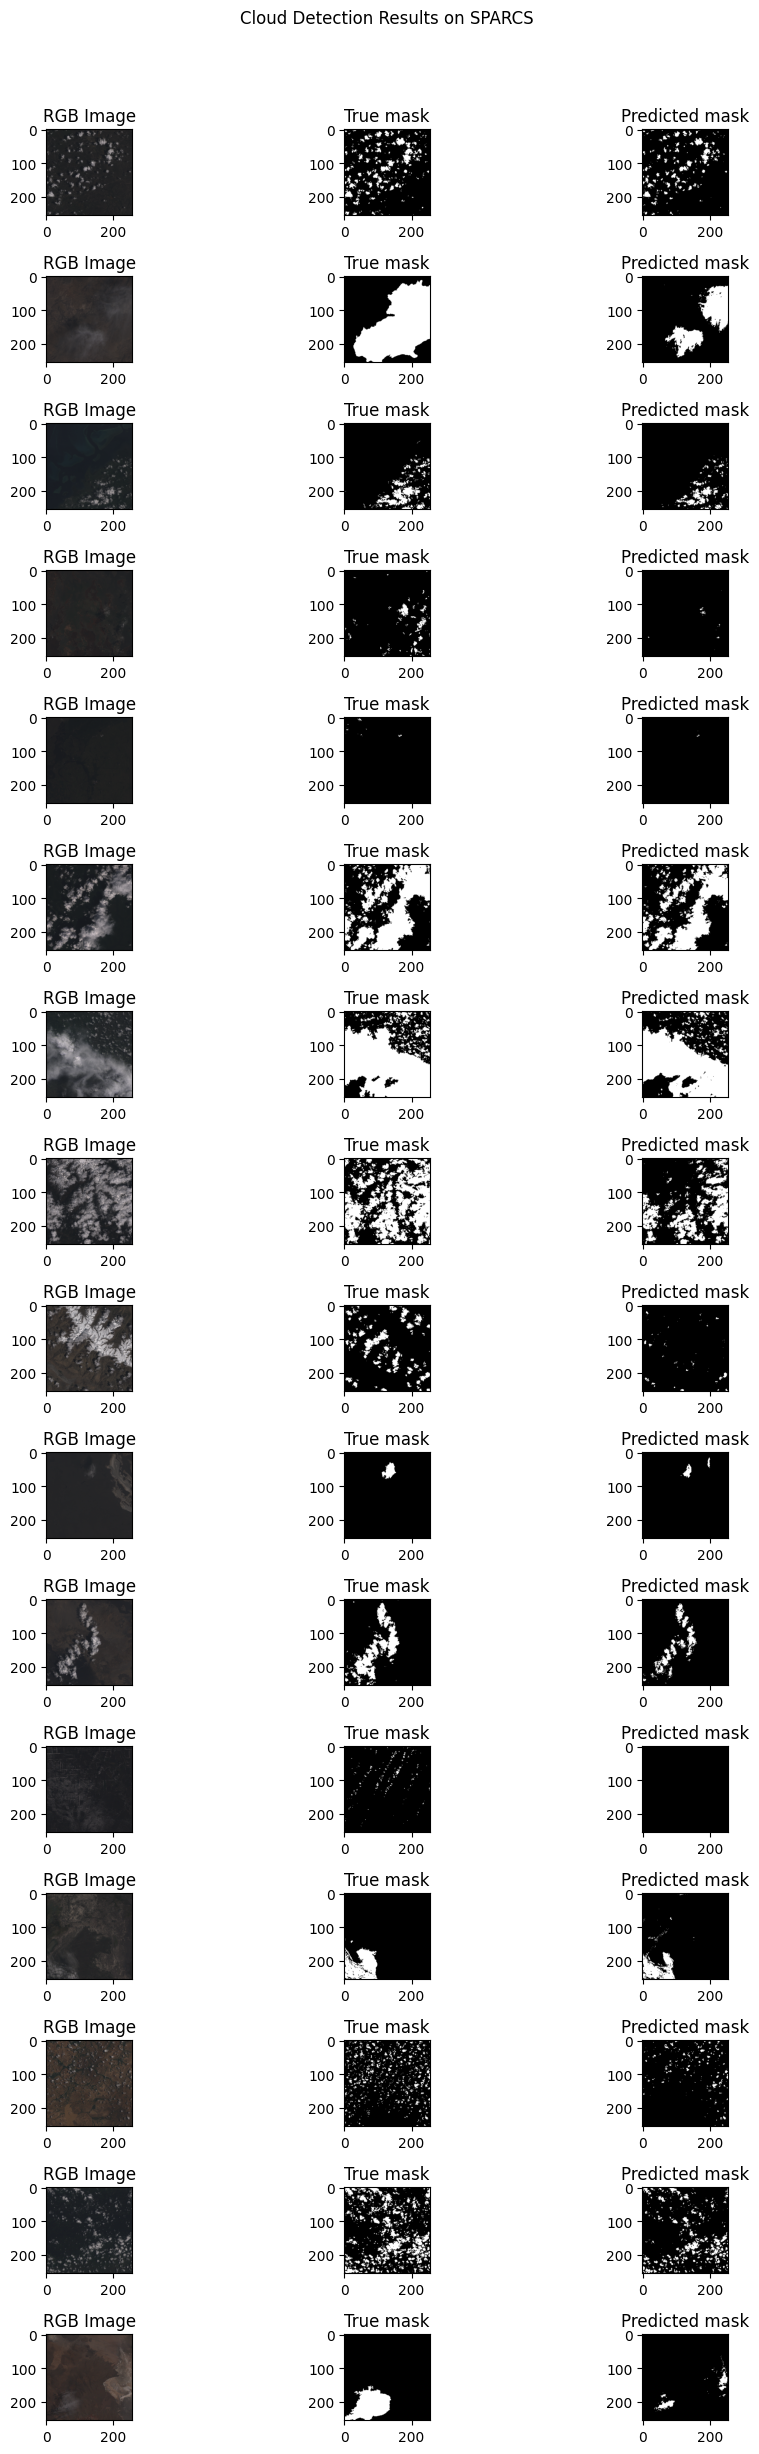

In [18]:
fig, ax = plt.subplots(len(images), 3, figsize=(10, 25))

for i, im in enumerate(images):
    # inputs, targets = test_list[idx]
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(masks[i], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(preds[i], cmap='gray')
    ax[i, 2].set_title('Predicted mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on SPARCS')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

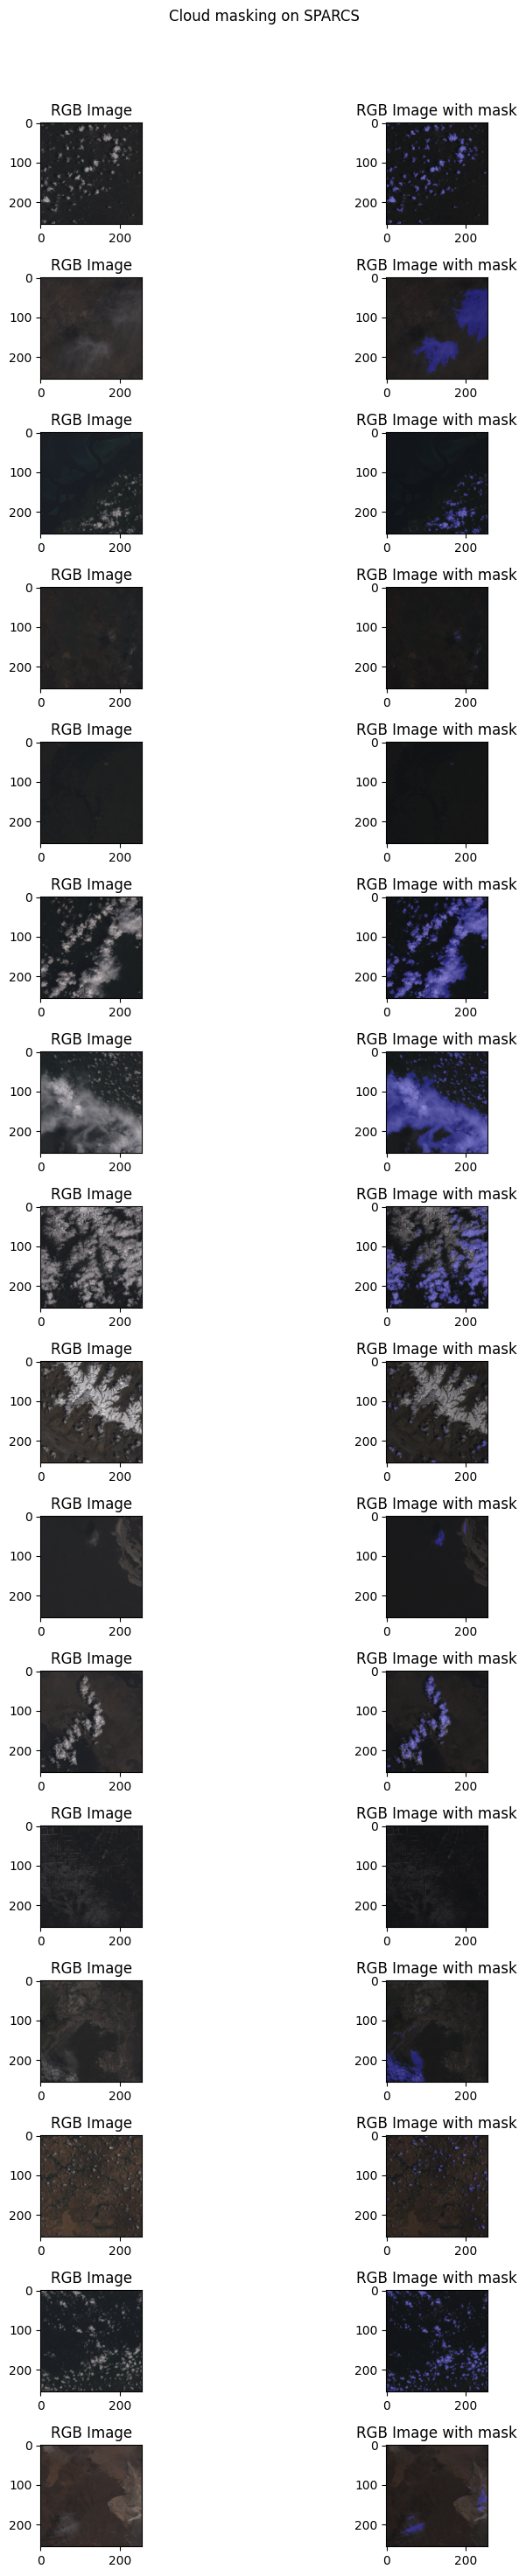

In [19]:
fig, ax = plt.subplots(len(images), 2, figsize=(10, 30))

for i, im in enumerate(images):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(preds[i])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(im)
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on SPARCS')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()

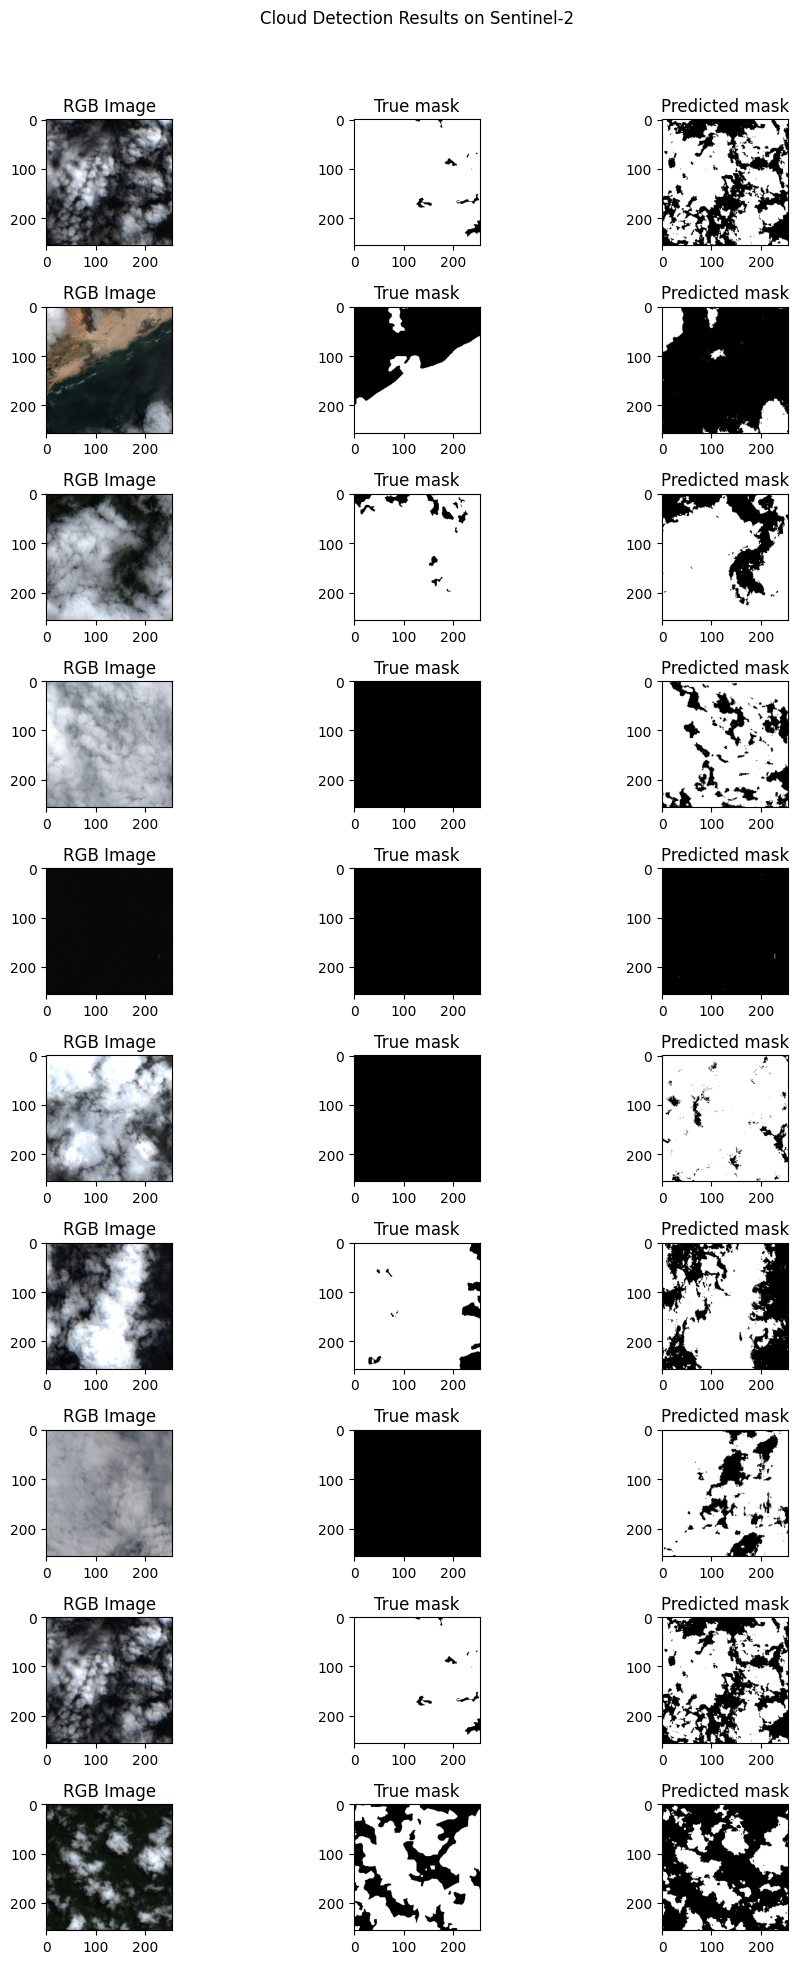

In [20]:
np.random.seed(seed_value)
idxs = np.random.randint(len(S2_images), size=10)

fig, ax = plt.subplots(len(idxs), 3, figsize=(10, 20))

for i, idx in enumerate(idxs):
    ax[i, 0].imshow(S2_images[idx])
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(S2_masks[idx], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(y_pred_binary_S2[idx], cmap='gray')
    ax[i, 2].set_title('Predicted mask')

# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on Sentinel-2')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

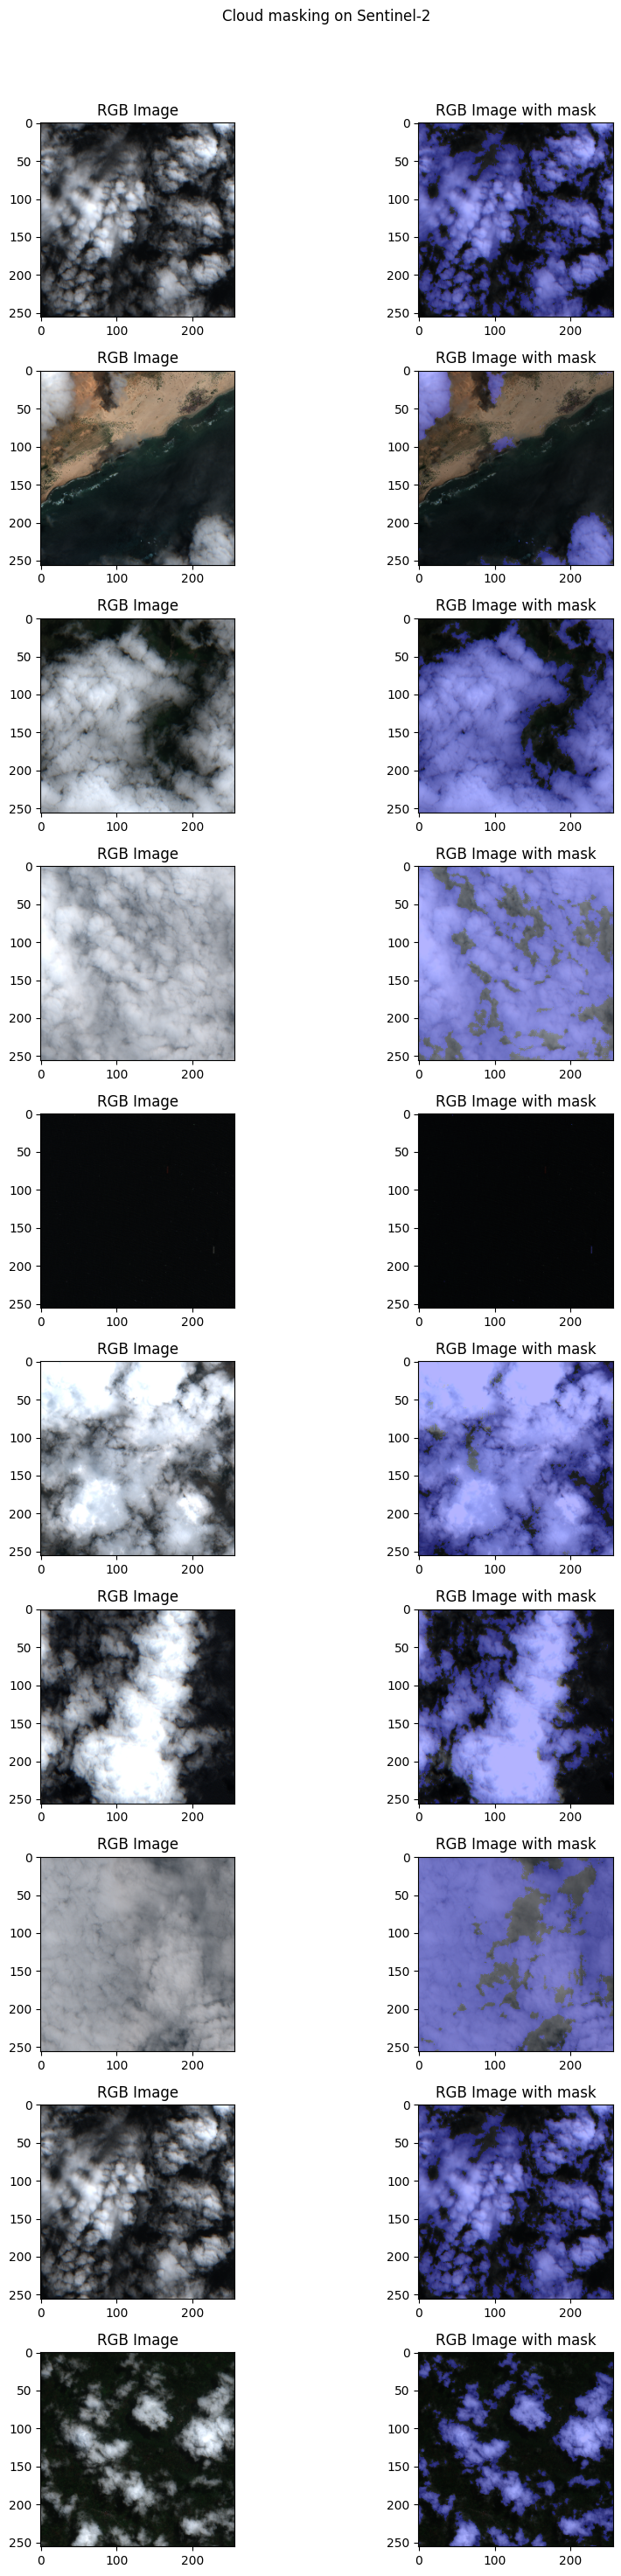

In [21]:
fig, ax = plt.subplots(len(idxs), 2, figsize=(10, 30))

for i, idx in enumerate(idxs):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(y_pred_binary_S2[idx])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(S2_images[idx])
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(S2_images[idx])
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on Sentinel-2')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()

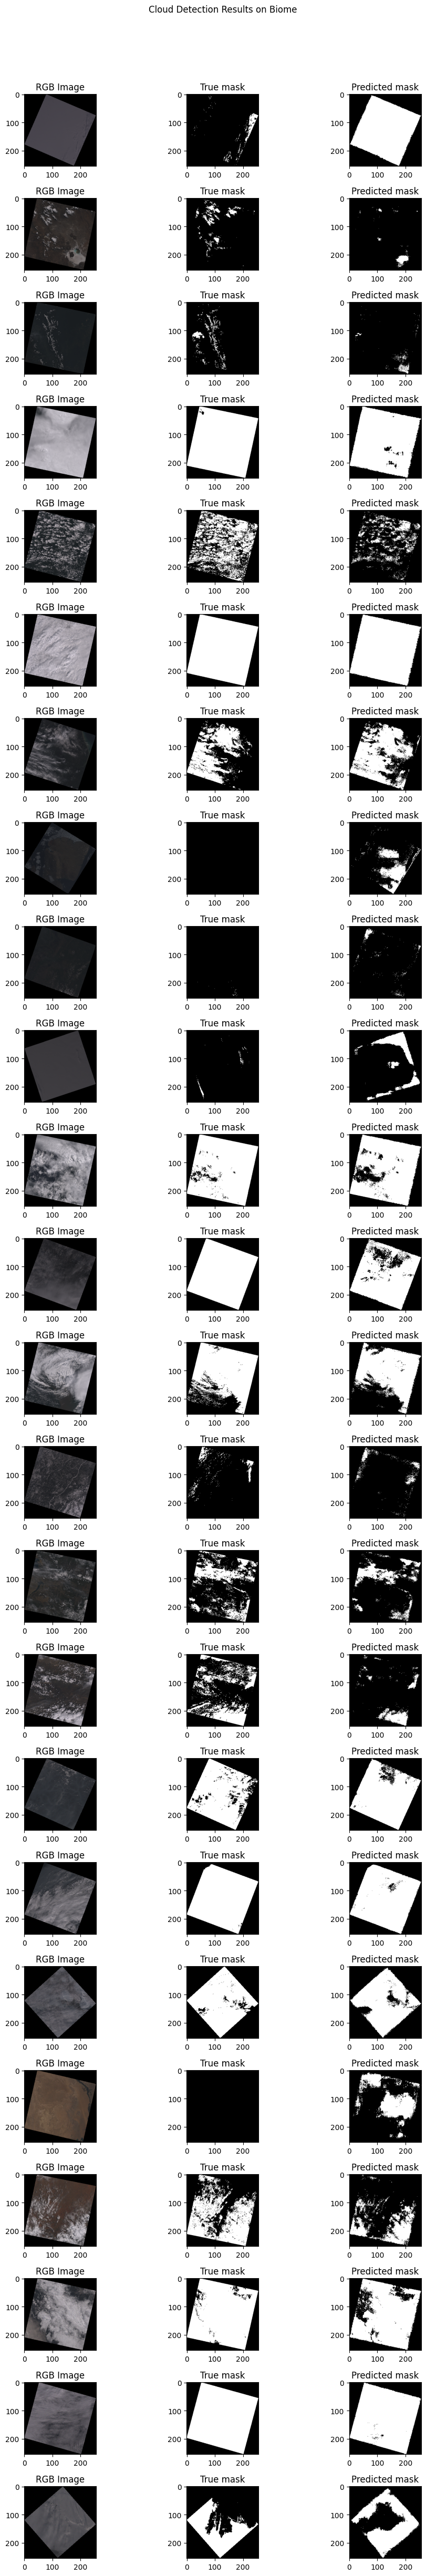

In [22]:
fig, ax = plt.subplots(len(biome_images), 3, figsize=(10, 50))

for i, im in enumerate(biome_images):
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    biome_masks[i][biome_masks[i] == 2] = 0
    ax[i, 1].imshow(biome_masks[i], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(biome_preds[i], cmap='gray')
    ax[i, 2].set_title('Predicted mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on Biome')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()

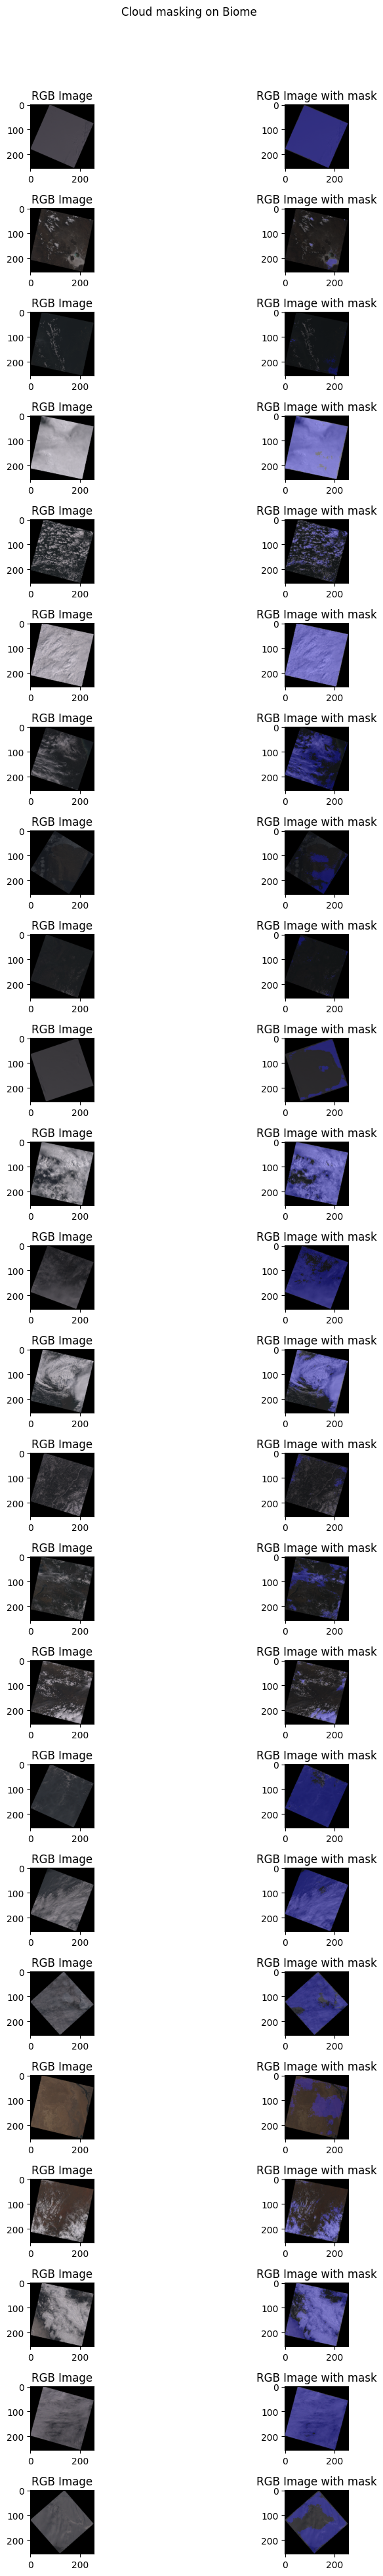

In [23]:
fig, ax = plt.subplots(len(biome_images), 2, figsize=(10, 40))

for i, im in enumerate(biome_images):
    # Remove singleton dimensions from preds[i]
    mask = np.squeeze(biome_preds[i])
    
    # Create an RGB mask where the masked region is light blue
    rgb_mask = np.zeros((*mask.shape, 3))
    rgb_mask[mask == 1] = [0, 0, 1]  # Light blue color for the mask
    
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    
    ax[i, 1].imshow(im)
    ax[i, 1].imshow(rgb_mask, alpha=0.3)  # Adjust alpha for desired transparency
    ax[i, 1].set_title('RGB Image with mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud masking on Biome')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the figure
plt.show()

In [24]:
# non_zero_indices = [index for index, img in enumerate(c95_images) if not np.any(img == 0)]
# non_zero_images = [c95_images[index] for index in non_zero_indices]

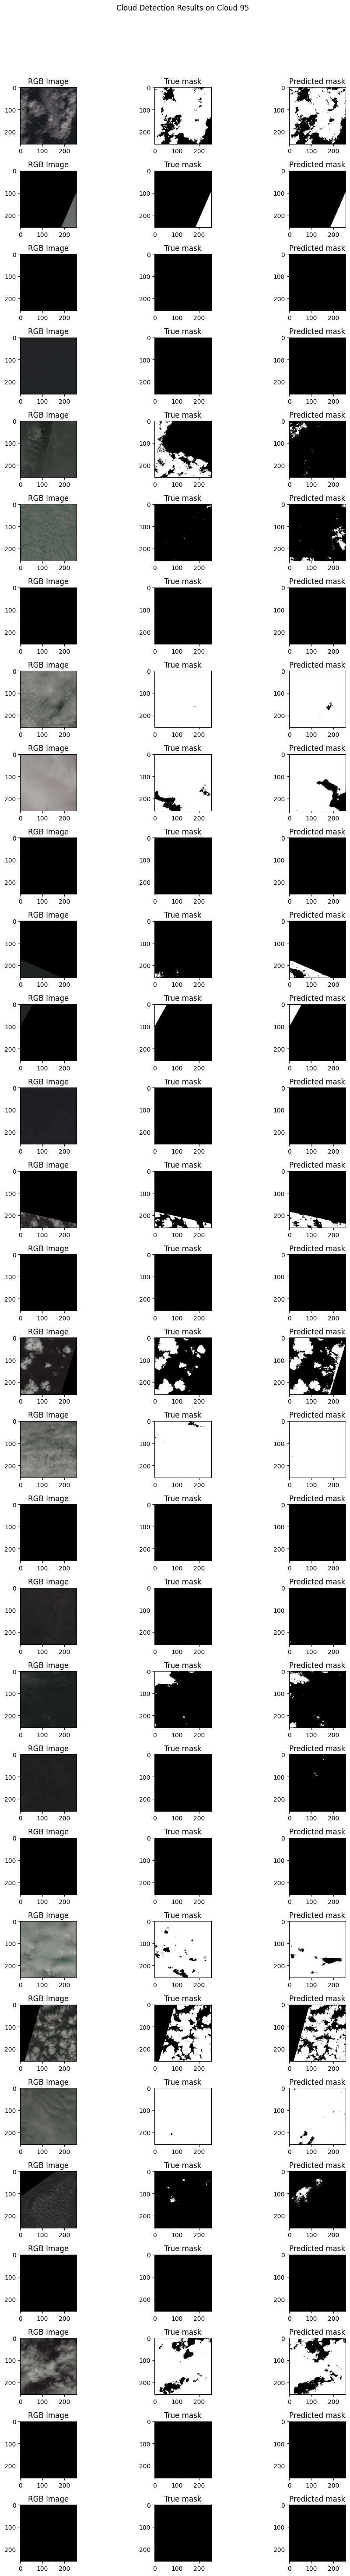

In [25]:
# c95_images = c95_images[non_zero_indices]
# c95_masks = c95_masks[non_zero_indices]
# c95_preds = c95_preds[non_zero_indices]

fig, ax = plt.subplots(len(c95_images), 3, figsize=(10, 60))

for i, im in enumerate(c95_images):
    ax[i, 0].imshow(im)
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(c95_masks[i], cmap='gray')
    ax[i, 1].set_title('True mask')
    ax[i, 2].imshow(c95_preds[i], cmap='gray')
    ax[i, 2].set_title('Predicted mask')
    
# Add a title for the entire plot
plt.suptitle('Cloud Detection Results on Cloud 95')

# Adjust the spacing between subplots and from the top of the figure
plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Display the figure
plt.show()